## Задание №2 

### Сгенерируйте датасет со случайными нормально распределенными величинами $x_1$, $x_2$, $x_3$ , $corr(x_1, x_2)=0.0$, $corr(x_1, x_3)=0.0$, $corr(x_2, x_3)=0.8$,размер выборки $N = 1000$ 

### $ y = \beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_3x_3 + \epsilon$

#### Необходимые функции:

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy import stats
import scipy as sci

In [5]:
def gen_data(y_type, params, seed):
    
    np.random.seed(seed)

    if y_type == 'multivariate':

        # Сгенерируем значения факторов и форму зависимости y от регрессоров
        means = [params['x1_mean'], params['x2_mean'], params['x3_mean']]

        # Вычислим наполнение матрицы ковариаций 
        var_1 = params['x1_std']**2
        var_2 = params['x2_std']**2
        var_3 = params['x3_std']**2

        cov_12 = params['corr_12'] * params['x1_std'] * params['x2_std']
        cov_13 = params['corr_13'] * params['x1_std'] * params['x3_std']
        cov_23 = params['corr_23'] * params['x2_std'] * params['x3_std']
        
        covs = [[var_1, cov_12, cov_13],
                [cov_12, var_2, cov_23],
                [cov_13, cov_23, var_3]]

        # Сгененрируем требующуюся выборку
        X = np.random.multivariate_normal(
            mean=means,
            cov=covs,
            size=params['N']
        )

        # А также сгененируем случайную ошибку как величину из нормального распределения
        e = np.random.normal(loc=params['e_mean'], scale=params['e_std'], size=params['N'])

        # Здесь мы создаем таргет 'y' как некую функцию от x1, x2 и ошибки e
        y = params['beta0'] \
            + params['beta1'] * X[:, 0] \
            + params['beta2'] * X[:, 1] \
            + params['beta3'] * X[:, 2] \
            + e

        # Для удобства сохраним вектора в pandas dataframe
        dataset = pd.DataFrame({'x1': X[:, 0], 'x2': X[:, 1], 'x3': X[:, 2], 'y': y, 'e': e})
        
    return(dataset)


def plot_data(dataset, target, feature_names, plot_type = None, pairwise=False, model=None):

    dataset = dataset.copy()
    # Графики с результатами моделирования
    if plot_type == 'model':

        if pairwise == True:
            
            feat = feature_names[0]
            # Давайте посмотрим, как соотносится реальная выборка с предсказанными значениями
            sns.scatterplot(data=dataset, x=feat, y=target);
            sns.lineplot(x=dataset[feat], y=dataset[f'{target}_hat'], c = 'r')
            plt.xlabel(f'{feat} values')
            plt.ylabel(f'{target} values')
            plt.title(f'{target} vs {feat} distribution and model fit')
            plt.show()

        else:

            # Чтобы сделать функцию гибкой, пройдемся по фичам из списка
            for feat in feature_names:
                
                
                '''
                Предскажем значение таргета при фиксированных средних
                значениях всех перменных, кроме рассматриваемой. И отрисуем
                зависимость между этим фактором и предсказанным таргетом
                '''
                dataset_paired = pd.DataFrame(
                    data = [dataset[feature_names].mean()],
                    index = dataset.index
                    )
                dataset_paired[feat] = dataset[feat]
                dataset_paired['const'] = 1.0
                dataset_paired = dataset_paired[['const'] + feature_names]
                target_paired = model.predict(dataset_paired)

                # Давайте посмотрим, как соотносится реальная выборка с предсказанными значениями
                sns.scatterplot(data=dataset, x=feat, y=target);
                sns.lineplot(x=dataset[feat], y=target_paired, c = 'r');
                plt.xlabel(f'{feat} values')
                plt.ylabel(f'{target} values')
                plt.title(f'{target} vs {feat} distribution and model fit')
                plt.show()

        # Отрисует предсказанные и реальные значения таргета
        sns.scatterplot(data=dataset, x=f'{target}_hat', y=target);
        sns.lineplot(data=dataset, x=target, y=target, c='black', linestyle='--');
        plt.xlabel('Predicted value')
        plt.ylabel('Actual value')
        plt.title('Model fit vs actual data')
        plt.show()

        # А также посмотрим на распределение остатков модели
        sns.displot(dataset['residuals'], bins=20, kde=True);
        plt.xlabel('Model residuals')
        plt.ylabel('Residuals frequency')
        plt.title('Model residuals histogram')
        plt.show()

    # Графики с базовыми распределениями факторов
    elif plot_type == 'EDA':
        
        # Чтобы сделать функцию гибкой, пройдемся по фичам из списка
        for feat in feature_names:

            # Отрисуем распределения нужных нам факторов
            sns.displot(dataset[feat], bins=20, kde=True);
            plt.xlabel(f'{feat} values')
            plt.ylabel(f'{feat} freq')
            plt.title(f'{feat} histogram and density plot')
            plt.show()

            # Также отрисуем зависимость между таргетом и интересующими факторами
            sns.scatterplot(data=dataset, x=feat, y='y');
            plt.xlabel(f'{feat} values')
            plt.ylabel('y values')
            plt.title(f'y vs {feat} distribution')
            plt.show()

def norm_distr_check (
        data,
        p_level:    float = 0.95):

    """
    Проверка нормальности распределения: возвращает DataFrame, содержащий 
    результаты проверки нормальности распределения с использованием различных
    тестов.
    

    Args:
        data:                                     
            исходный массив данных.
            
        p_level (float, optional):           
            доверительная вероятность. 
            Defaults to 0.95.

    Returns:
        result (pd.core.frame.DataFrame):
            результат 
    
    Notes:
        1. Функция реализует следующие тесты:
            - тест Шапиро-Уилка (Shapiro-Wilk test) (при 8 <= N <= 1000)
            - тест Эппса-Палли (Epps_Pulley_test) (при N >= 8)
            - тест Д'Агостино (K2-test)
            - тест Андерсона-Дарлинга (Anderson-Darling test)
            - тест Колмогорова-Смирнова (Kolmogorov-Smirnov test) (при N >= 50)
            - тест Лиллиефорса (Lilliefors’ test)
            - тест Крамера-Мизеса-Смирнова (Cramér-von Mises test) (при N >= 40)
            - тест Пирсона (хи-квадрат) (chi-square test) (при N >= 100)
            - тест Харке-Бера (Jarque-Bera tes) (при N >= 2000)
            - тест асимметрии (при N >= 8)
            - тест эксцесса (при N >= 20)            
            
        2. Функция требует наличия файла table\Epps_Pulley_test_table.csv, 
            который содержит табличные значения критерия Эппса-Палли.
            
    """    
    
    a_level = 1 - p_level
    X = np.array(data)
    N = len(X)
       
    # тест Шапиро-Уилка (Shapiro-Wilk test)
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html
    if N >= 8:
        result_ShW = sci.stats.shapiro(X)
        s_calc_ShW = result_ShW.statistic
        a_calc_ShW = result_ShW.pvalue
        conclusion_ShW = 'gaussian distribution' if a_calc_ShW >= a_level \
            else 'not gaussian distribution'
    else:
        result_ShW = '-'
        s_calc_ShW = '-'
        a_calc_ShW = '-'
        conclusion_ShW = 'count less than 8'

    # тест Эппса-Палли (Epps_Pulley_test)
    сdf_beta_I = lambda x, a, b: sci.stats.beta.cdf(x, a, b, loc=0, scale=1)
    g_beta_III = lambda z, δ: δ*z / (1+(δ-1)*z)
    cdf_beta_III = \
        lambda x, θ0, θ1, θ2, θ3, θ4: \
            сdf_beta_I(g_beta_III((x - θ4)/θ3, θ2), θ0, θ1)
    
    θ_1 = (1.8645, 2.5155, 5.8256, 0.9216, 0.0008)    # для 15 < n < 50
    θ_2 = (1.7669, 2.1668, 6.7594, 0.91, 0.0016)    # для n >= 50
    
    if N >= 8 and N <= 1000:
        X_mean = X.mean()
        m2 = np.var(X, ddof = 0)
        # расчетное значение статистики критерия
        A = np.sqrt(2) * np.sum([np.exp(-(X[i] - X_mean)**2 / (4*m2)) 
                              for i in range(N)])
        B = 2/N * np.sum(
            [np.sum([np.exp(-(X[j] - X[k])**2 / (2*m2)) for j in range(0, k)]) 
             for k in range(1, N)])
        s_calc_EP = 1 + N / np.sqrt(3) + B - A
        # табличное значение статистики критерия
        Tep_table_df = pd.read_csv(
            filepath_or_buffer='table/Epps_Pulley_test_table.csv',
            sep=';',
            index_col='n')
        p_level_dict = {
            0.9:   Tep_table_df.columns[0],
            0.95:  Tep_table_df.columns[1],
            0.975: Tep_table_df.columns[2],
            0.99:  Tep_table_df.columns[3]}
        f_lin = sci.interpolate.interp1d(Tep_table_df.index, \
                                         Tep_table_df[p_level_dict[p_level]])
        critical_value_EP = float(f_lin(N))
        # проверка гипотезы
        if 15 < N < 50:
            a_calc_EP = 1 - cdf_beta_III(s_calc_EP, θ_1[0], θ_1[1], \
                                         θ_1[2], θ_1[3], θ_1[4])
            conclusion_EP = 'gaussian distribution' if a_calc_EP > a_level \
                else 'not gaussian distribution'            
        elif N >= 50:
            a_calc_EP = 1 - cdf_beta_III(s_calc_EP, θ_2[0], θ_2[1], \
                                         θ_2[2], θ_2[3], θ_2[4])
            conclusion_EP = 'gaussian distribution' if a_calc_EP > a_level \
                else 'not gaussian distribution'            
        else:
            a_calc_EP = ''              
            conclusion_EP = 'gaussian distribution' \
                if s_calc_EP <= critical_value_EP \
                    else 'not gaussian distribution'            
                
    elif N > 1000:
        s_calc_EP = '-'
        critical_value_EP = '-'
        a_calc_EP = '-'
        conclusion_EP = 'count more than 1000'
    else:
        s_calc_EP = '-'
        critical_value_EP = '-'
        a_calc_EP = '-'
        conclusion_EP = 'count less than 8'
    
    
    # тест Д'Агостино (K2-test)
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html
    if N >= 8:
        result_K2 = sci.stats.normaltest(X)
        s_calc_K2 = result_K2.statistic
        a_calc_K2 = result_K2.pvalue
        conclusion_K2 = 'gaussian distribution' if a_calc_K2 >= a_level \
            else 'not gaussian distribution'
    else:
        s_calc_K2 = '-'
        a_calc_K2 = '-'
        conclusion_K2 = 'count less than 8'
    
    # тест Андерсона-Дарлинга (Anderson-Darling test)
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html
    result_AD = sci.stats.anderson(X)
    df_AD = pd.DataFrame({
        'a_level (%)': result_AD.significance_level,
        'statistic': [result_AD.statistic 
                      for i in range(len(result_AD.critical_values))],
        'critical_value': result_AD.critical_values
        })
    statistic_AD = float(df_AD[df_AD['a_level (%)'] == round((1 - p_level)*100, 1)]['statistic'].iloc[0])
    critical_value_AD = float(df_AD[df_AD['a_level (%)'] == round((1 - p_level)*100, 1)]['critical_value'].iloc[0])
    conclusion_AD = 'gaussian distribution' \
        if statistic_AD < critical_value_AD else 'not gaussian distribution'
    
    # тест Колмогорова-Смирнова (Kolmogorov-Smirnov test)
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html#scipy.stats.kstest
    if N >= 50:
        result_KS = sci.stats.kstest(X, 'norm')
        s_calc_KS = result_KS.statistic
        a_calc_KS = result_KS.pvalue
        conclusion_KS = 'gaussian distribution' if a_calc_KS >= a_level \
            else 'not gaussian distribution'
    else:
        s_calc_KS = '-'
        a_calc_KS = '-'
        conclusion_KS = 'count less than 50'
        
    # тест Лиллиефорса (Lilliefors’ test)
    # https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.lilliefors.html
    from statsmodels.stats.diagnostic import lilliefors
    s_calc_L, a_calc_L = sm.stats.diagnostic.lilliefors(X, 'norm')
    conclusion_L = 'gaussian distribution' if a_calc_L >= a_level \
        else 'not gaussian distribution'  
    
    # тест Крамера-Мизеса-Смирнова (Cramér-von Mises test)
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.cramervonmises.html#scipy-stats-cramervonmises
    if N >= 40:
        result_CvM = sci.stats.cramervonmises(X, 'norm')
        s_calc_CvM = result_CvM.statistic
        a_calc_CvM = result_CvM.pvalue
        conclusion_CvM = 'gaussian distribution' if a_calc_CvM >= a_level \
            else 'not gaussian distribution'
    else:
        s_calc_CvM = '-'
        a_calc_CvM = '-'
        conclusion_CvM = 'count less than 40'
    
    # тест Пирсона (хи-квадрат) (chi-square test)
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html#scipy-stats-chisquare
    if N >= 100:
        ddof = 2    # поправка к числу степеней свободы 
                    # (число параметров распределения, оцениваемое по выборке)
        result_Chi2 = sci.stats.chisquare(X, ddof=ddof)
        s_calc_Chi2 = result_Chi2.statistic
        a_calc_Chi2 = result_Chi2.pvalue
        conclusion_Chi2 = 'gaussian distribution' if a_calc_Chi2 >= a_level \
            else 'not gaussian distribution'
    else:
        s_calc_Chi2 = '-'
        a_calc_Chi2 = '-'
        conclusion_Chi2 = 'count less than 100'
        
    # тест Харке-Бера (асимметрии и эксцесса) (Jarque-Bera tes)
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.jarque_bera.html#scipy-stats-jarque-bera
    if N >= 2000:
        result_JB = sci.stats.jarque_bera(X)
        s_calc_JB = result_JB.statistic
        a_calc_JB = result_JB.pvalue
        conclusion_JB = 'gaussian distribution' if a_calc_JB >= a_level \
            else 'not gaussian distribution'
    else:
        s_calc_JB = '-'
        a_calc_JB = '-'
        conclusion_JB = 'count less than 2000'
    
    # тест асимметрии
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewtest.html#scipy-stats-skewtest
    if N >= 8:
        result_As = sci.stats.skewtest(X)
        s_calc_As = result_As.statistic
        a_calc_As = result_As.pvalue
        conclusion_As = 'gaussian distribution' if a_calc_As >= a_level \
            else 'not gaussian distribution'
    else:
        s_calc_As = '-'
        a_calc_As = '-'
        conclusion_As = 'count less than 8'
     
    # тест эксцесса
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosistest.html#scipy-stats-kurtosistest
    if N > 20:
        result_Es = sci.stats.kurtosistest(X)
        s_calc_Es = result_Es.statistic
        a_calc_Es = result_Es.pvalue
        conclusion_Es = 'gaussian distribution' if a_calc_Es >= a_level \
            else 'not gaussian distribution'
    else:
        s_calc_Es = '-'
        a_calc_Es = '-'
        conclusion_Es = 'count less than 20'
    
    # Создадим DataFrame для сводки результатов    
    result = pd.DataFrame({
    'test': (
        'Shapiro-Wilk test',
        'Epps-Pulley test',
        "D'Agostino's K-squared test",
        'Anderson-Darling test',
        'Kolmogorov–Smirnov test',
        'Lilliefors test',
        'Cramér–von Mises test',
        'Chi-squared test',
        'Jarque–Bera test',
        'skewtest',
        'kurtosistest'),
    'p_level': (p_level),
    'a_level': (a_level),
    'a_calc': (
        a_calc_ShW,
        a_calc_EP,
        a_calc_K2,
        '',
        a_calc_KS,
        a_calc_L,
        a_calc_CvM,
        a_calc_Chi2,
        a_calc_JB,
        a_calc_As,
        a_calc_Es),
    'a_calc >= a_level': (
        a_calc_ShW >= a_level if N >= 8 else '-',
        a_calc_EP >= a_level if N > 15 and N <= 1000 else '-',
        a_calc_K2 >= a_level if N >= 8 else '-',
        '',
        a_calc_KS >= a_level if N >= 50 else '-',
        a_calc_L >= a_level,
        a_calc_CvM >= a_level if N >= 40 else '-',
        a_calc_Chi2 >= a_level if N >= 100 else '-',
        a_calc_JB >= a_level if N >= 2000 else '-',
        a_calc_As >= a_level if N >= 8 else '-',
        a_calc_Es >= a_level if N > 20 else '-'),
    'statistic': (
        s_calc_ShW,
        s_calc_EP,
        s_calc_K2,
        statistic_AD,
        s_calc_KS,
        s_calc_L,
        s_calc_CvM,
        s_calc_Chi2,
        s_calc_JB,
        s_calc_As,
        s_calc_Es),
    'critical_value': (
        '',
        critical_value_EP,
        '',
        critical_value_AD,
        '', '', '', '', '', '', ''),
    'statistic < critical_value': (
        '',
        s_calc_EP < critical_value_EP  if N >= 8 else '-',
        '',
        statistic_AD < critical_value_AD,
        '', '', '', '', '', '', ''),
    'conclusion': (
        conclusion_ShW,
        conclusion_EP,
        conclusion_K2,
        conclusion_AD,
        conclusion_KS,
        conclusion_L,
        conclusion_CvM,
        conclusion_Chi2,
        conclusion_JB,
        conclusion_As,
        conclusion_Es
        )})  
        
    return result

def train_model(dataset, target, feature_names, show_results=False, pairwise=False, return_norm_tests=False):

    dataset = dataset.copy()

    # Создадим матрицу фичей как фактор x1 и единичный вектор, на который будет фиттиться константа
    X = sm.add_constant(dataset[feature_names])
    
    # Зафитим модель на данные. y - наша целевая переменная, X - матрица факторов
    model = sm.OLS(dataset[target], X).fit()
    
    dataset[f'{target}_hat'] = model.fittedvalues
    dataset['residuals'] = model.resid
    
    if show_results:
        # Выведем результат построения регрессии
        print(model.summary())
        
        # Выведем графики с результатами модели
        plot_data(dataset, target, feature_names, plot_type='model', pairwise=pairwise, model=model)
        
    # Выведем саммари по тестам
    if return_norm_tests:
        display(norm_distr_check(
            (dataset['residuals'] - np.mean(dataset['residuals']))\
                /np.std(dataset['residuals'])
            ))
    
    return(dataset, model)

### Оцените коэффициенты модели методом МНК, выведите репорт с результатами модели, дайте трактовку полученным результатам:

#### 1.Значения оценок $\beta_1$ и $\beta_2$, $\beta_3$ в стравнении с реальными коэффициентами.

In [6]:
dist_params = dict(

    # Зададим параметры распределения факторов
    x1_mean = 15.0,
    x1_std = 5.5,
    x2_mean = 10.0,
    x2_std = 4.0,
    x3_mean = 8.0,
    x3_std = 3.0,
    
    # Зададим параметры распределения ошибки
    e_mean = 0.0,
    e_std = 2.0,
    
    # Зададим параметры корреляции факторов
    corr_12 = 0.0,
    corr_13 = 0.0,
    corr_23 = 0.8,

    # Укажем размер выборки
    N = 1000,

    # Зададим действительные параметры модели
    beta0 = 78.0,
    beta1 = 6.8,
    beta2 = 1.2,
    beta3 = 14.1
)

RANDOM_SEED = 42

In [7]:
dt_heteroskedasticity = gen_data(y_type='multivariate', params=dist_params, seed=RANDOM_SEED)

,x1,x2,x3,y,e
0,17.731928,9.978972,9.179453,336.166550,-3.815615
1,23.376664,11.117181,8.350120,366.317863,-1.720770
2,23.685670,7.409698,5.321707,322.163059,-0.827211
3,17.984080,12.213066,8.690029,341.252207,3.775375
4,16.330792,18.965522,11.093812,369.343873,1.113106
...,...,...,...,...,...
995,9.719745,10.398321,8.450901,275.786879,0.056915
996,8.783880,-0.731211,3.286088,179.031144,-4.155624
997,18.311651,9.902483,7.540499,320.082650,-0.640596
998,9.764448,9.474190,8.107264,273.366461,3.286756


array([[<Axes: xlabel='x1', ylabel='x1'>,
        <Axes: xlabel='x2', ylabel='x1'>,
        <Axes: xlabel='x3', ylabel='x1'>,
        <Axes: xlabel='e', ylabel='x1'>],
       [<Axes: xlabel='x1', ylabel='x2'>,
        <Axes: xlabel='x2', ylabel='x2'>,
        <Axes: xlabel='x3', ylabel='x2'>,
        <Axes: xlabel='e', ylabel='x2'>],
       [<Axes: xlabel='x1', ylabel='x3'>,
        <Axes: xlabel='x2', ylabel='x3'>,
        <Axes: xlabel='x3', ylabel='x3'>,
        <Axes: xlabel='e', ylabel='x3'>],
       [<Axes: xlabel='x1', ylabel='e'>, <Axes: xlabel='x2', ylabel='e'>,
        <Axes: xlabel='x3', ylabel='e'>, <Axes: xlabel='e', ylabel='e'>]],
      dtype=object)

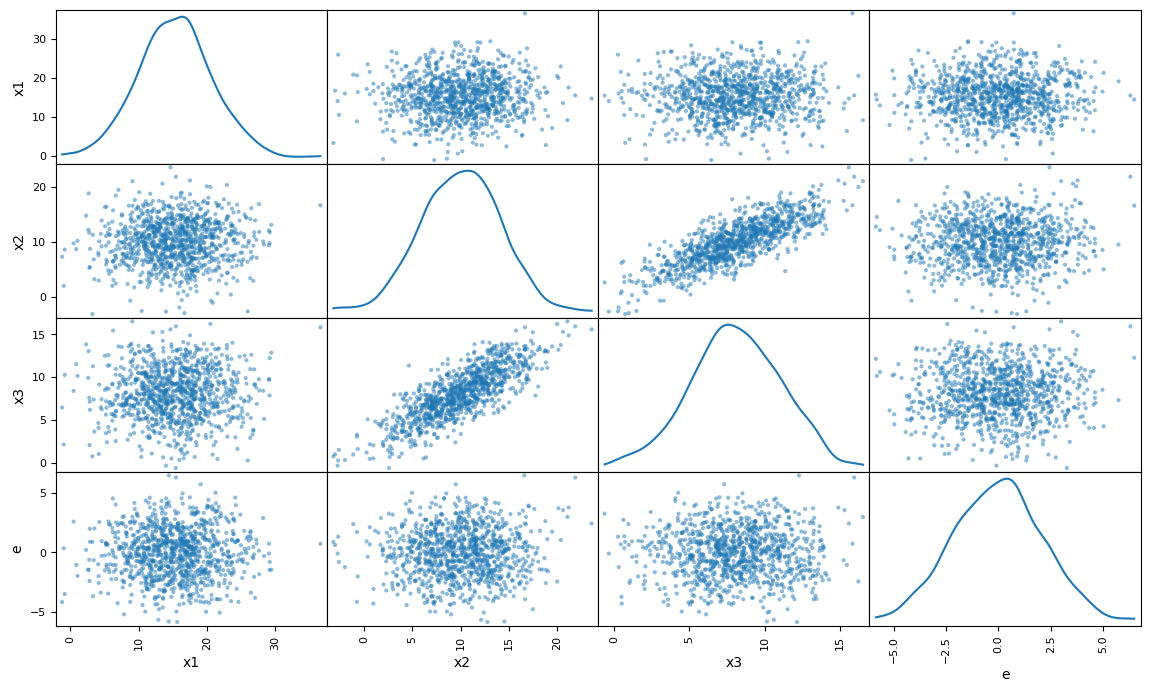

In [8]:
display(dt_heteroskedasticity)

# Посмотрим на корреляции глазами
pd.plotting.scatter_matrix(dt_heteroskedasticity[['x1', 'x2', 'x3', 'e']], figsize = (14,8), diagonal = 'kde')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.804e+05
Date:                Sat, 02 Mar 2024   Prob (F-statistic):               0.00
Time:                        10:57:41   Log-Likelihood:                -2137.2
No. Observations:                1000   AIC:                             4282.
Df Residuals:                     996   BIC:                             4302.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         77.7699      0.262    297.214      0.0

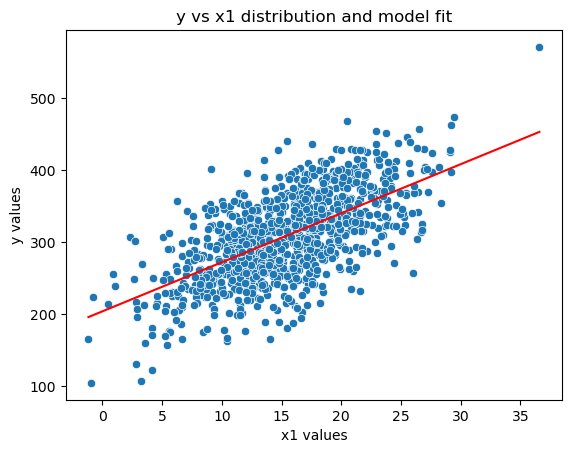

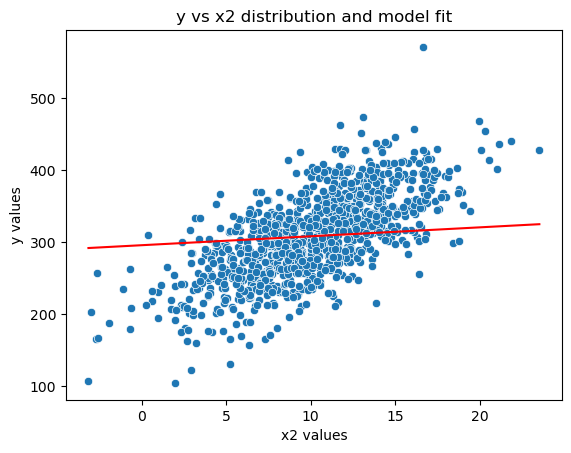

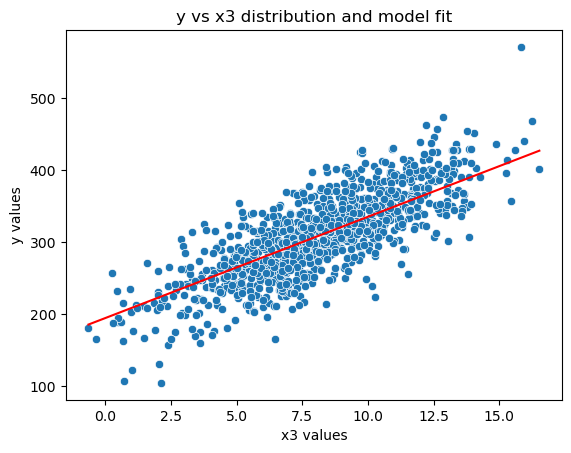

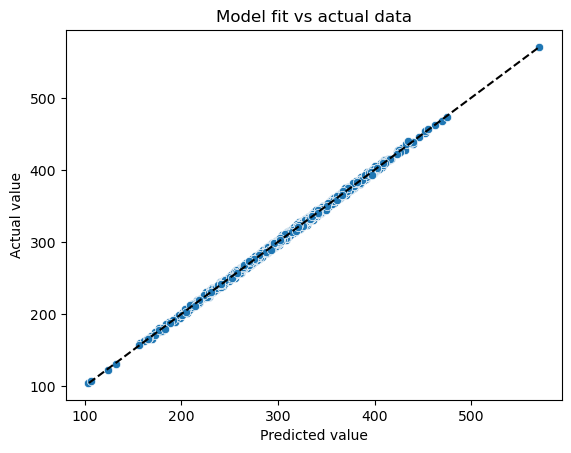

d:\Users\nik_p\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


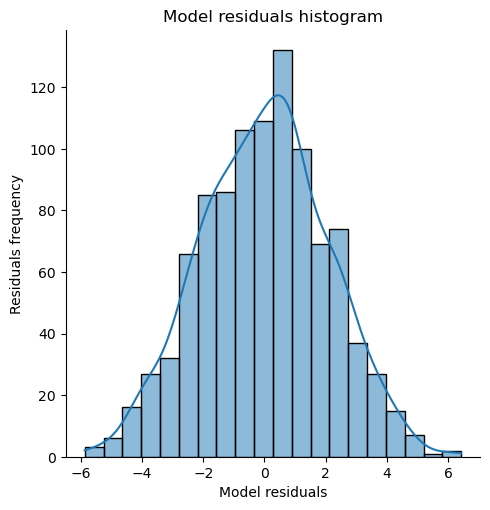

In [9]:
# Строим OLS модель с обычной матрицей ошибок
dt_heteroskedasticity, model_heteroskedasticity = train_model(
    dt_heteroskedasticity, target='y', feature_names=['x1', 'x2', 'x3'], show_results=True, return_norm_tests=False)

### Истинные значения коэффициентов:
$ \beta_0 = 78.0$

$ \beta_1 = 6.8$

$ \beta_2 = 1.2 $
    
$ \beta_3 = 14.1 $
### Значения оценок:
$ \hat{\beta_0} = 77.7699$

$ \hat{\beta_1} =6.8062$

$ \hat{\beta_2} = 1.2381  $
    
$ \hat{\beta_3} = 14.0651 $
##### $\bullet$ Коэффициенты $\hat{\beta_0}$, $\hat{\beta_1}$, $\hat{\beta_2}$ и $\hat{\beta_3}$ очень близки к истинным значениям коэффициентов.
##### $\bullet$ Коэффициенты $\hat{\beta_0}$, $\beta_1$, $\beta_2$ и $\beta_3$ попадают в свои доверительные итервалы, значит можно сделать вывод о том, что наша модель корректна.

### 2. Значения стандартных ошибок коэффициентов, значения t-статистик, p-value, доверительных интервалов.

#### $\bullet$ Значения стандартных ошибок:
$ \sigma_0 = 0.262$

$ \sigma_1 = 0.012 $

$ \sigma_2 = 0.027  $
    
$ \sigma_3 = 0.037$

#### Стандартные ошибки малы, что сигнализирует о малом разбросе значений.  

#### $\bullet$ Значения t-статистик:

$ t_0 = 297.214 $

$ t_1 = 557.911$

$ t_2 = 45.577$

$ t_3 = 379.579$

##### Значения статистик высокие. Это значит, что все коэффициенты стат. значимы.

#### $\bullet$ Все значения p-value близки к 0.

##### Делаем вывод, что все коэффициенты стат. значимы.

#### $\bullet$ Доверительные интервалы:

Для $\beta_0$: [77.256; 78.283]

Для $\beta_1$: [6.782; 6.830]

Для $\beta_2$: [1.185; 1.291]

Для $\beta_3$: [13.992; 14.138]

##### Доверительные интервалы включают в себя истинные значения коэффициентов. Исходя из этого делаем вывод о том, что модель корректна.

### 3. Значение F-статистики, критериев AIC и BIC.

#### $\bullet$ F-статистика:
$ F = 2.804e+05$ 

$Prob(F-statistic) =  0.00$

##### Делаем вывод о том, что все коэффициенты модели стат. значимы.

#### $\bullet$ Критерий AIC 

$AIC = 4282$

##### Используется для выбора лучшей модели(с минимальным AIC). Ниже для примера построил модель на $x_1$ и $x_2$. У модели выше, AIC меньше => отдаем предпочтение ей.

#### $\bullet$ Критерий BIC 

$BIC = 4302$

##### Также как и AIC спользуется для выбора лучшей модели(с минимальным BIC). Ниже для примера построил модель на $x_1$ и $x_2$. У модели выше, BIC меньше => отдаем предпочтение ей.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     2396.
Date:                Sat, 02 Mar 2024   Prob (F-statistic):               0.00
Time:                        10:57:42   Log-Likelihood:                -4627.8
No. Observations:                1000   AIC:                             9262.
Df Residuals:                     997   BIC:                             9276.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.9416      2.997     36.351      0.0

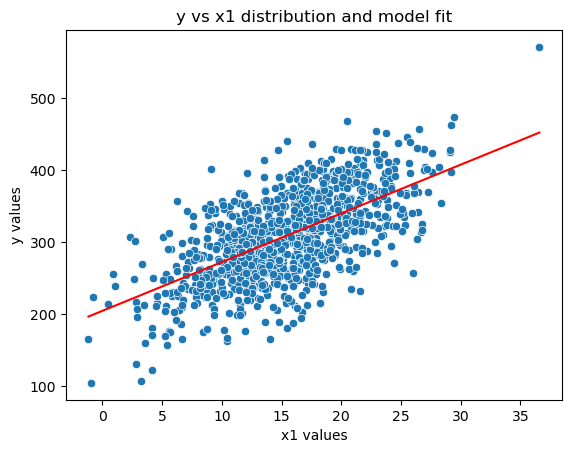

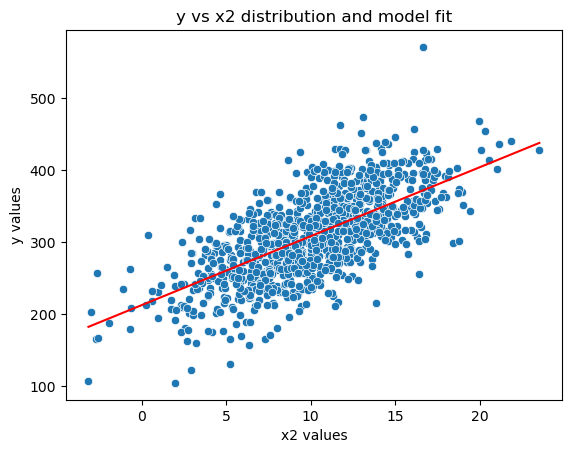

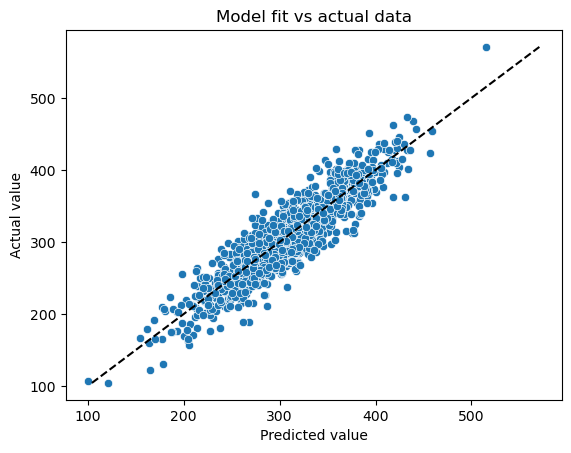

d:\Users\nik_p\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


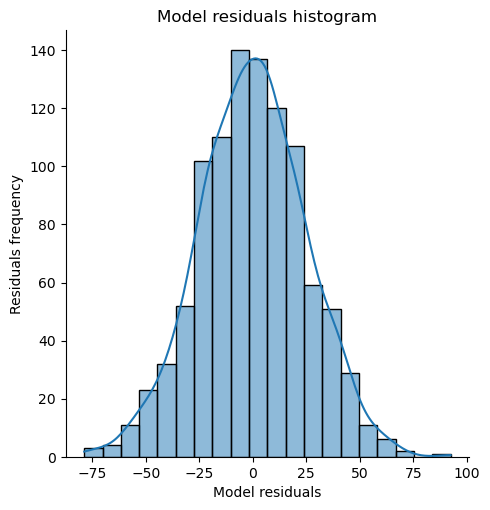

In [10]:
dt_heteroskedasticity, model_heteroskedasticity = train_model(
    dt_heteroskedasticity, target='y', feature_names=['x1', 'x2'], show_results=True, return_norm_tests=False)